# Fake News detection project

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from wordcloud import WordCloud # type: ignore
from collections import Counter
import nltk
import pickle
from nltk.corpus import stopwords # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
import gensim.downloader as api

In [4]:
# %pip install pdfplumber
# %pip install nbformat
# %pip pandas==2.2.3
# %pip install matplotlib==3.9.2
# %pip install scipy==1.13.1
# %pip install pyarrow==18.0.0
# %pip install scikit-learn==1.5.2
# %pip install statsmodels==0.14.4
# %pip install seaborn
# %pip install plotly
# %pip install wordcloud
# %pip install nltk
# %pip install tf-keras
# %pip install gensim
# %pip install numpy==1.24.6
# %pip install spacy

### Import data

- ISOT Dataset (https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset?resource=download&select=Fake.csv 
& https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset/data?select=True.csv)

In [4]:
df_isot_true = pd.read_csv("./data/True.csv", encoding="utf-8")
df_isot_fake = pd.read_csv("./data/Fake.csv", encoding="utf-8")

df_isot_true["label"] = "TRUE"
df_isot_fake["label"] = "FAKE"

# combine both datasets into one
df_isot = pd.concat([df_isot_true, df_isot_fake], ignore_index=True)
df_isot.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE


- Fake or Real News Dataset (https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news/data)

In [5]:
df_fake_or_real = pd.read_csv("./data/fake_or_real_news.csv", encoding='utf-8')
df_fake_or_real.rename(columns={'Unnamed: 0': 'number'}, inplace=True)
df_fake_or_real.head(5)

,number,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Data Analysis

- ISOT Dataset

In [6]:
print(f"Dataset shape :{df_isot.shape}")
print(f"There are {len(df_isot.columns)} columns: {df_isot.columns}")
print(df_isot.info())
print(df_isot.isnull().sum())
df_isot.describe(include='all')

Dataset shape :(44898, 5)
There are 5 columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
title      0
text       0
subject    0
date       0
label      0
dtype: int64


,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",FAKE
freq,14,627,11272,182,23481


In [7]:
custom_palette = {
    'FAKE': 'indianred', # '#FF6347',
    'TRUE': 'lightgreen'# '#4CAF50'
}

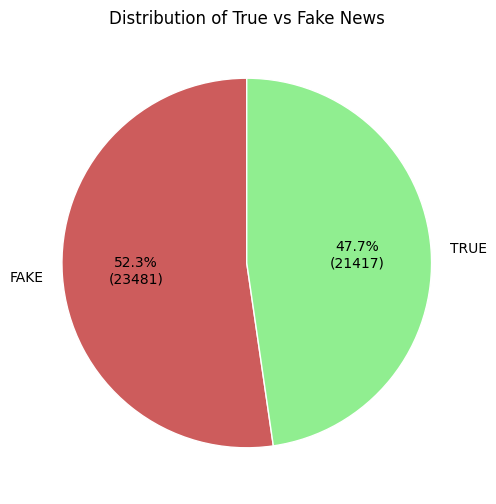

In [8]:
# Pie chart of True vs Fke counts
label_counts = df_isot['label'].value_counts()

# formatting function for labels
def format_label(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(6, 6))
colors = [custom_palette[label] for label in label_counts.index]
plt.pie(label_counts, labels=label_counts.index, startangle=90, wedgeprops={'edgecolor': 'white'},
        autopct=lambda pct: format_label(pct, label_counts), colors=colors)
plt.title("Distribution of True vs Fake News")
plt.show()

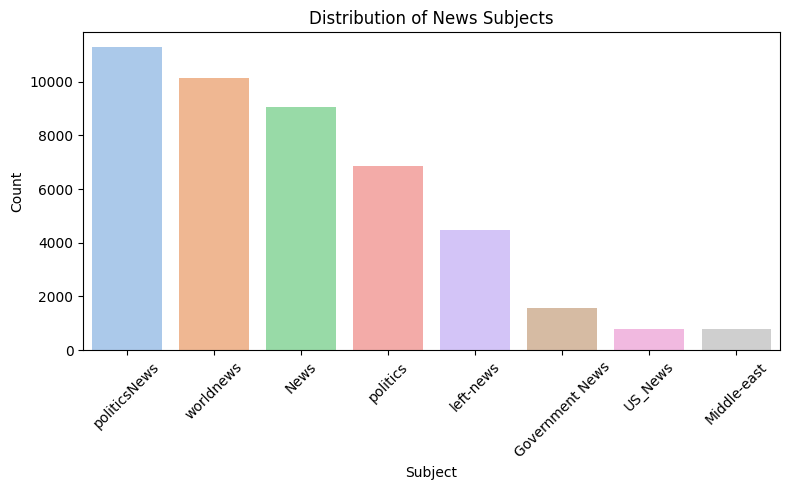

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [9]:
# Bar plot of the different subjects of articles
subject_counts = df_isot['subject'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='pastel')
plt.title("Distribution of News Subjects")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df_isot['subject'].value_counts()

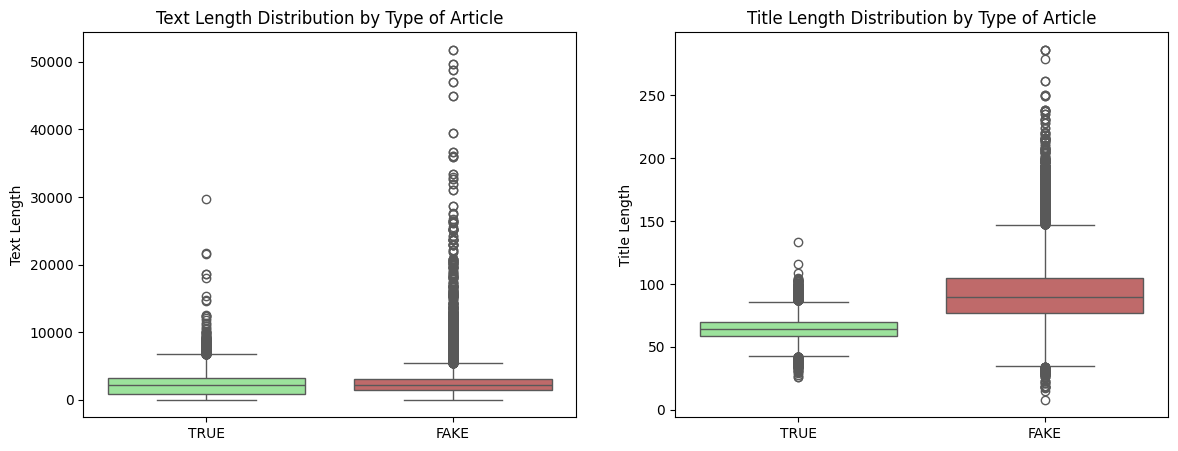

In [10]:
# Box plots for fake vs Truetext length and title length distributions

df_isot['text_length'] = df_isot['text'].apply(len)
df_isot['title_length'] = df_isot['title'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df_isot, x='label', y='text_length', palette=custom_palette, hue='label', ax=axes[0])
axes[0].set_title("Text Length Distribution by Type of Article")
axes[0].set_xlabel("")
axes[0].set_ylabel("Text Length")

sns.boxplot(data=df_isot, x='label', y='title_length', palette=custom_palette, ax=axes[1])
axes[1].set_title("Title Length Distribution by Type of Article")
axes[1].set_ylabel("Title Length")
axes[1].set_xlabel("")

plt.show()

##### Topic exploration
To get a global idea of what topics the speeches treat of
- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIdf_isot Vectorizer


In [11]:
nltk.download('stopwords')

# join all articles' texts for true and fake news :
true_text = ' '.join(df_isot[df_isot.label == 'TRUE']['text'])
fake_text = ' '.join(df_isot[df_isot.label == 'FAKE']['text'])
# combine all articles :
# all_text = ' '.join([true_text, fake_text])

# Normalize to lowercase and count word frequencies
true_words = [word.lower() for word in true_text.split()]
true_word_counts = Counter(true_words)
fake_words = [word.lower() for word in fake_text.split()]
fake_word_counts = Counter(fake_words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
true_filtered_word_counts = {word: count for word, count in true_word_counts.items() if word not in stop_words}
fake_filtered_word_counts = {word: count for word, count in fake_word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To reduce the impact over large tfidf_isot coefficients, we use the log transformation $x \rightarrow log(1+x)$

In [12]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15, # appears in at least 15 docs
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
    max_features=5000
)

X_ = vectorizer.fit_transform(df_isot_true['text'])
cols = vectorizer.get_feature_names_out()
true_tfidf_isot_matrix = X_.toarray() # convert the TF-Idf_isot matrix as a dense array
true_tfidf_isot = pd.DataFrame(np.log1p(true_tfidf_isot_matrix), columns=cols) #index=df_isot["text"].index,

X_ = vectorizer.fit_transform(df_isot_fake['text'])
cols = vectorizer.get_feature_names_out()
fake_tfidf_isot_matrix = X_.toarray() # convert the TF-Idf_isot matrix as a dense array
fake_tfidf_isot = pd.DataFrame(np.log1p(fake_tfidf_isot_matrix), columns=cols) # index=df_isot["text"].index, 


# Calculate the sum of the TF-Idf_isot scores for each term across all articles
sum_tfidf_isot_scores_true = true_tfidf_isot_matrix.sum(axis=0)
sum_tfidf_isot_scores_fake = fake_tfidf_isot_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-Idf_isot score as values
word_freq_true = dict(zip(cols, sum_tfidf_isot_scores_true))
word_freq_fake = dict(zip(cols, sum_tfidf_isot_scores_fake))

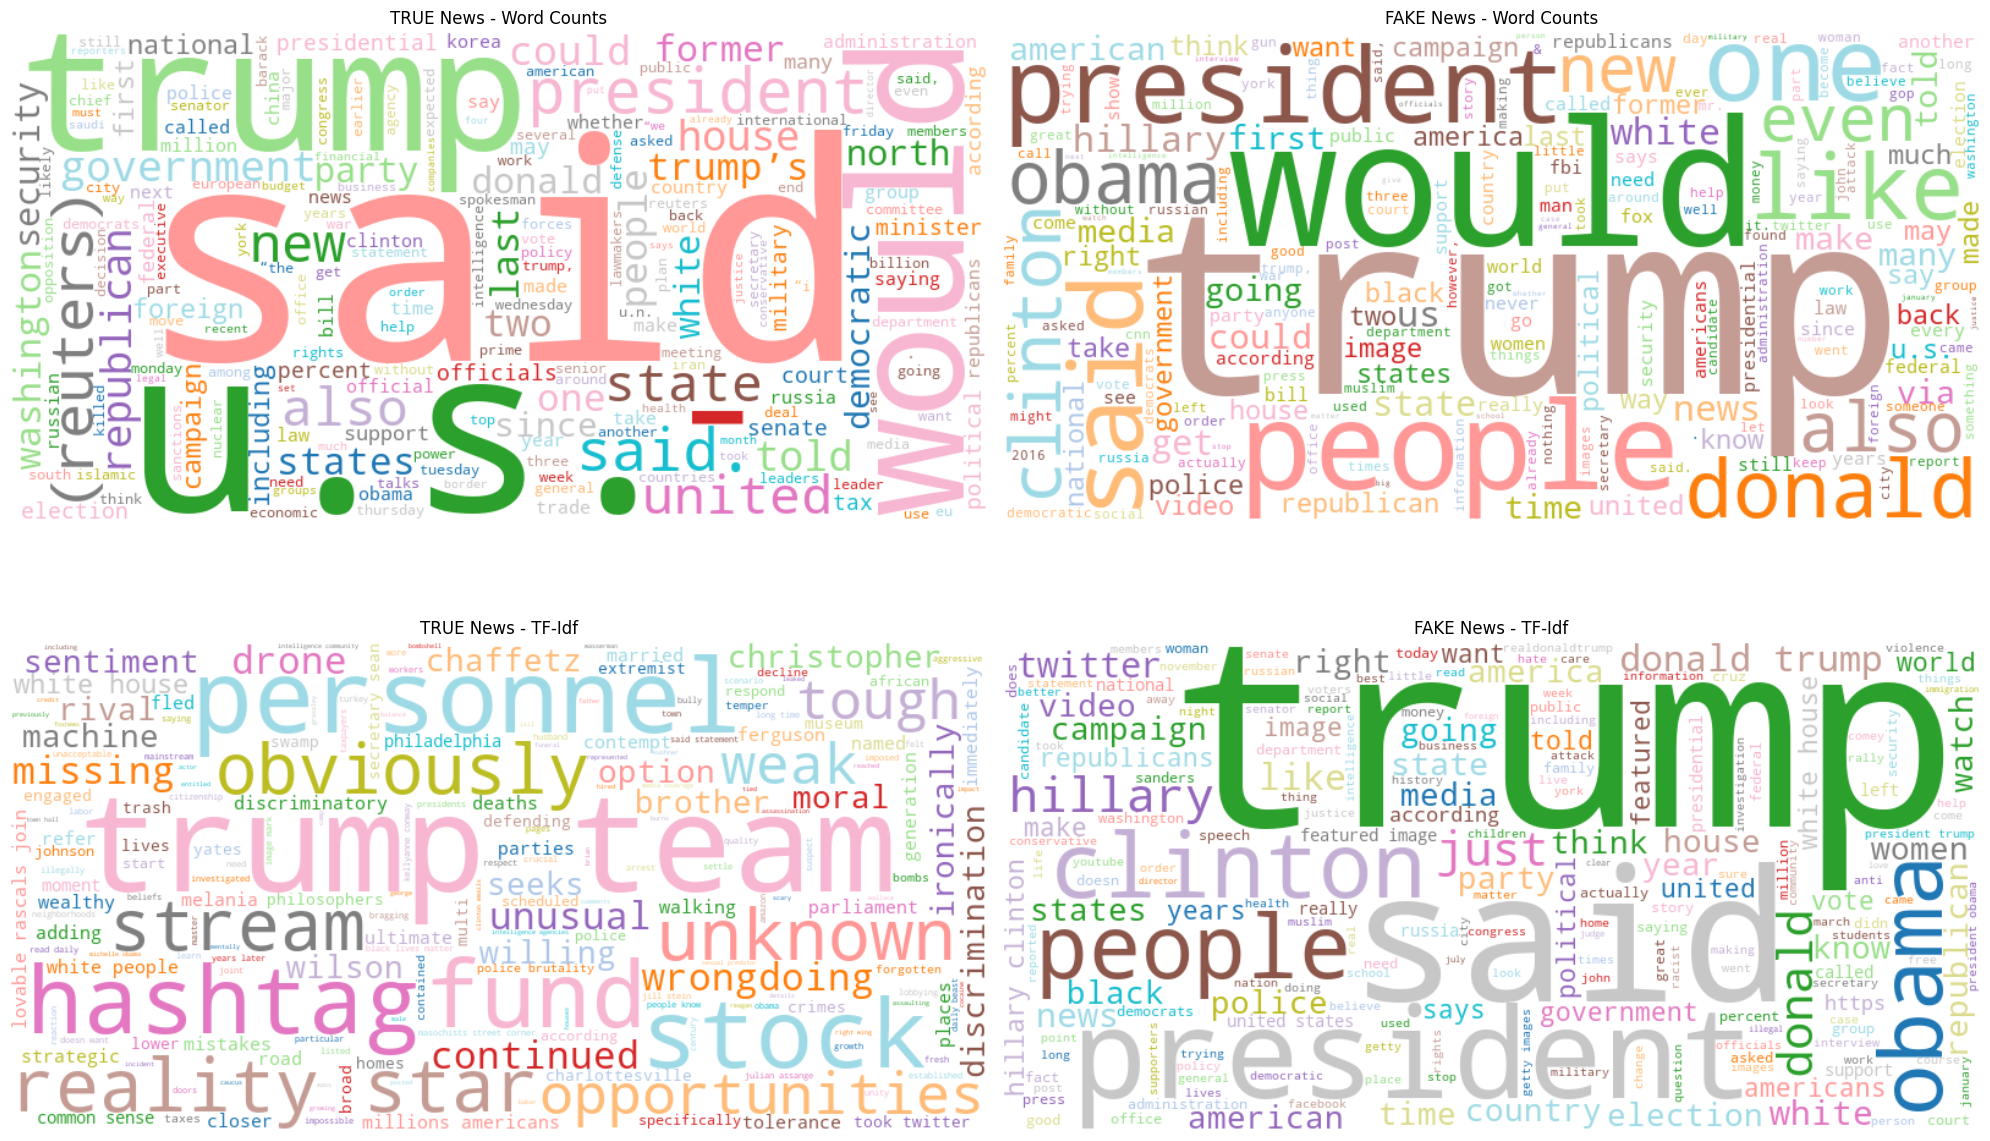

In [13]:
# Generate word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# according to word counts
wordcloud_counts_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(true_filtered_word_counts)
wordcloud_counts_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(fake_filtered_word_counts)

# according to TF-Idf_isot scores
wordcloud_tfidf_isot_true = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_true)
wordcloud_tfidf_isot_fake = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq_fake)

# plot
axes[0, 0].imshow(wordcloud_counts_true, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('TRUE News - Word Counts')

axes[0, 1].imshow(wordcloud_counts_fake, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('FAKE News - Word Counts')

axes[1, 0].imshow(wordcloud_tfidf_isot_true, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('TRUE News - TF-Idf')

axes[1, 1].imshow(wordcloud_tfidf_isot_fake, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('FAKE News - TF-Idf')


plt.subplots_adjust(hspace=1, wspace=30)

plt.tight_layout()
plt.show()

In [14]:
print("Top 20 REAL words:")
print(list(true_filtered_word_counts.items())[:20])

print("\nTop 20 FAKE words:")
print(list(fake_filtered_word_counts.items())[:20])

Top 20 REAL words:
[('washington', 10785), ('(reuters)', 21239), ('-', 31059), ('head', 2665), ('conservative', 3005), ('republican', 14500), ('faction', 137), ('u.s.', 38276), ('congress,', 791), ('voted', 1396), ('month', 3087), ('huge', 520), ('expansion', 350), ('national', 8085), ('debt', 1281), ('pay', 1937), ('tax', 7388), ('cuts,', 130), ('called', 6013), ('“fiscal', 8)]

Top 20 FAKE words:
[('donald', 16800), ('trump', 65511), ('wish', 550), ('americans', 5091), ('happy', 829), ('new', 13941), ('year', 4167), ('leave', 1376), ('that.', 1585), ('instead,', 699), ('give', 3149), ('shout', 64), ('enemies,', 54), ('haters', 78), ('dishonest', 217), ('fake', 2786), ('news', 12123), ('media.', 570), ('former', 7016), ('reality', 1354)]


- Fake or Real Dataset

In [15]:
print(f"Dataset shape :{df_fake_or_real.shape}")
print(f"There are {len(df_fake_or_real.columns)} columns: {df_fake_or_real.columns}")
print(df_fake_or_real.info())
print(df_fake_or_real.isnull().sum())
df_fake_or_real.describe(include='all')

Dataset shape :(6335, 4)
There are 4 columns: Index(['number', 'title', 'text', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   number  6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None
number    0
title     0
text      0
label     0
dtype: int64


,number,title,text,label
count,6335.000000,6335,6335,6335
unique,NaN,6256,6060,2
top,NaN,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,NaN,5,58,3171
mean,5280.415627,NaN,NaN,NaN
std,3038.503953,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,2674.500000,NaN,NaN,NaN
50%,5271.000000,NaN,NaN,NaN
75%,7901.000000,NaN,NaN,NaN


In [17]:
# # DATA EXPLORATION FOR FAKE OR REAL NEWS DATASET

### Data Preprocessing

Convert text to lowercase + tokenize + remove stopwords + apply lemmatization

In [5]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 93.9 kB/s eta 0:02:17
     ---------------------------------------- 0.0/12.8 MB 93.9 kB/s eta 0:02:17
     --------------------------------------- 0.0/12.8 MB 109.5 kB/s eta 0:01:57
     --------------------------------------- 0.0/12.8 MB 140.9 kB/s eta 0:01:31
     --------------------------------------- 0.1/12.8 MB 182.2 kB/s eta 0:01:10
      -------------------------------------- 0.3/12.8 MB 716.5 kB/s eta 0:00:18
     -- ------------------------------------- 0.7/12.8 MB 1.7 MB/s eta 0:00:07
     ---- ----------------------------------- 1.4/12.8 MB 3.1 MB/s eta 0:00:04
     ------ --------------------------------- 2.1/12.8 MB 4.3 MB/s eta 0:00:03
     -------- ------------------------------- 2.9/12.8 MB 5.5 MB/s 


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from nltk.tokenize import word_tokenize
import string
import re
import spacy

# Load a spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nltk.download('punkt')
nltk.download('punkt_tab')

punctuations = set(string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
def clean_text(text):
    # lowercase
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)  # keeps only words and spaces
    # tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return " ".join(tokens)  # cleaned text back as string

df_isot['clean_text'] = df_isot['text'].progress_apply(clean_text)
# 2m20

100%|██████████| 44898/44898 [01:31<00:00, 489.36it/s] 


In [19]:
# Lemmatization
def preprocess_text(text):
    doc = nlp(text)  # Convert text to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# load from parquet file if already computed, else compute the lemmatization
if os.path.exists('data/df_isot_temp.pkl'):
    df_isot = pd.read_pickle('data/df_isot_temp.pkl')
    # df_isot = pd.read_parquet("data/df_isot_temp.parquet")
    # df_isot = pd.read_csv("data/df_isot_temp.csv")
else:
    df_isot['lemma'] = df_isot['clean_text'].progress_apply(lambda doc: preprocess_text(doc).split())
    df_isot["lemma_str"] = df_isot["lemma"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
# 24m

Preprocessing is limited for Bert and Word2Vec models : only text to lowercase

In [20]:
df_isot['text_BERT'] = df_isot['text'].progress_apply(lambda text: text.lower())

100%|██████████| 44898/44898 [00:00<00:00, 61271.68it/s] 


In [61]:
os.makedirs("data", exist_ok=True)
# df_isot.to_parquet('data/df_isot_temp.parquet', engine="fastparquet")
# df_isot.to_csv(r'data/df_isot_temp.csv')
# Save the DataFrame with pickle
df_isot.to_pickle('data/df_isot_temp.pkl')
df_isot.head(5)

### Feature Extraction

- Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# create the vectorizer object
bow_vectorizer = CountVectorizer(max_features=1000)

# Fit and transform the corpus
X_bow = bow_vectorizer.fit_transform(df_isot["lemma_str"])

print("Vocabulary:", bow_vectorizer.get_feature_names_out())

Vocabulary: ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2012'
 '2013' '2014' '2015' '2016' '2017' '21st' '21wire' '22' '24' '25' '30'
 '50' 'able' 'abortion' 'absolutely' 'abuse' 'accept' 'access' 'accord'
 'account' 'accusation' 'accuse' 'act' 'action' 'activist' 'activity'
 'actually' 'ad' 'add' 'address' 'administration' 'admit' 'adviser'
 'advocate' 'affect' 'afghanistan' 'african' 'agency' 'agenda' 'agent'
 'ago' 'agree' 'agreement' 'ahead' 'aid' 'aide' 'aim' 'air' 'al'
 'allegation' 'allege' 'allow' 'ally' 'ambassador' 'amendment' 'america'
 'american' 'americans' 'announce' 'answer' 'anti' 'apparently' 'appeal'
 'appear' 'approach' 'approve' 'april' 'arabia' 'area' 'argue' 'arm'
 'armed' 'army' 'arrest' 'article' 'ask' 'assault' 'associate' 'attack'
 'attempt' 'attend' 'attention' 'attorney' 'august' 'authority' 'avoid'
 'away' 'back' 'bad' 'ban' 'bank' 'bar' 'barack' 'base' 'battle' 'bear'
 'begin' 'behavior' 'beijing' 'believe' 'benefit' 'bernie' 'big'

- TFIDF

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_isot["lemma_str"])

print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())

Vocabulary: ['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2012'
 '2013' '2014' '2015' '2016' '2017' '21st' '21wire' '22' '24' '25' '30'
 '50' 'able' 'abortion' 'absolutely' 'abuse' 'accept' 'access' 'accord'
 'account' 'accusation' 'accuse' 'act' 'action' 'activist' 'activity'
 'actually' 'ad' 'add' 'address' 'administration' 'admit' 'adviser'
 'advocate' 'affect' 'afghanistan' 'african' 'agency' 'agenda' 'agent'
 'ago' 'agree' 'agreement' 'ahead' 'aid' 'aide' 'aim' 'air' 'al'
 'allegation' 'allege' 'allow' 'ally' 'ambassador' 'amendment' 'america'
 'american' 'americans' 'announce' 'answer' 'anti' 'apparently' 'appeal'
 'appear' 'approach' 'approve' 'april' 'arabia' 'area' 'argue' 'arm'
 'armed' 'army' 'arrest' 'article' 'ask' 'assault' 'associate' 'attack'
 'attempt' 'attend' 'attention' 'attorney' 'august' 'authority' 'avoid'
 'away' 'back' 'bad' 'ban' 'bank' 'bar' 'barack' 'base' 'battle' 'bear'
 'begin' 'behavior' 'beijing' 'believe' 'benefit' 'bernie' 'big'

- Word2Vec

The resulting document vector is the mean of the word vectors for each word in the document. This is to aggregate word-level embeddings into document-level embeddings.

In [23]:
# Load the pretrained Word2Vec model
import gensim.downloader as api

In [24]:
# Define a function to convert a document to a vector by averaging the embeddings of its words
def get_document_vector(doc, model):
    tokens = doc.split()
    # get vectors for each word in the document
    word_vectors = []
    for word in tokens:
        if word in model.key_to_index:
            word_vectors.append(model[word])
    
    # if no valid word vectors, return a zero-vector
    if not word_vectors:
        return np.zeros(model.vector_size)
    
    # average the word vectors
    return np.mean(word_vectors, axis=0)

# create a folder to save the word2vec and bert embeddings locally to avoid recomputing them a second time
os.makedirs("embeddings", exist_ok=True)


# load from pickle file if already computed, else compute the embeddings
if os.path.exists('embeddings/word2vec_embeddings.pkl'):
    with open('embeddings/word2vec_embeddings.pkl', 'rb') as f:
        df_isot['word2vec'] = pickle.load(f)
else:
    wv = api.load('word2vec-google-news-300') # 11m
    df_isot['word2vec'] = df_isot['text_BERT'].apply(lambda x: get_document_vector(x, wv))
    # save to pickle file
    with open('embeddings/word2vec_embeddings.pkl', 'wb') as f:
        pickle.dump(df_isot['word2vec'], f)

df_isot['word2vec'].head()

0    [0.03163108, 0.02999982, 0.04029426, 0.1054190...
1    [-0.017906586, 0.044353463, 0.059727278, 0.075...
2    [0.016446222, 0.04384317, 0.045156073, 0.06268...
3    [0.0075391564, 0.036518387, 0.04778956, 0.0296...
4    [0.02672058, 0.02246702, 0.013854568, 0.066357...
Name: word2vec, dtype: object

- BERT features

In [25]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [26]:
def get_bert_embedding_batch(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move input tensors to GPU
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Get mean of token embeddings for each sentence
    return embeddings

# load from pickle file if already computed, else compute the embeddings
if os.path.exists('embeddings/bert_embeddings.pkl'):
    print("Loading from stored embeddings")
    with open('embeddings/bert_embeddings.pkl', 'rb') as f:
        df_isot['bert_embedding'] = pickle.load(f)
else:
    print("Creating the embeddings")
    # apply in batches
    batch_size = 32
    texts = df_isot["text_BERT"].tolist()

    batch_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        batch_embeddings.append(get_bert_embedding_batch(batch))

    # Flatten the list of embeddings into the dataframe
    df_isot["bert_embedding"] = [embedding for batch in batch_embeddings for embedding in batch]

    # save the embeddings to avoid recomputing multiple times (to pickle file)
    with open('embeddings/bert_embeddings.pkl', 'wb') as f:
        pickle.dump(df_isot["bert_embedding"], f)

df_isot['bert_embedding'].head(5)

Loading from stored embeddings


0    [-0.2688839, -0.25826722, 0.29003006, 0.099937...
1    [-0.23842482, -0.11807711, 0.09419881, -0.1364...
2    [-0.27059704, -0.23865652, 0.007694112, 0.0466...
3    [-0.26409382, -0.14432934, 0.007504974, -0.028...
4    [-0.26578832, -0.0722467, 0.23141108, 0.094295...
Name: bert_embedding, dtype: object

In [113]:
import boto3
import io
from dotenv import load_dotenv
load_dotenv()

aws_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_session = os.getenv("AWS_SESSION_TOKEN")

# Set up S3 client
s3 = boto3.client("s3",endpoint_url = 'https://'+'minio.lab.sspcloud.fr',
                  aws_access_key_id=aws_id, 
                  aws_secret_access_key=aws_secret, 
                  aws_session_token=aws_session
)
bucket_name = "mmeyer"


# # Serialize your embeddings to a buffer
# buffer = io.BytesIO()
# pickle.dump(df_isot["bert_embedding"], buffer)
# buffer.seek(0)

# # Upload to S3
# object_name = "embeddings/bert_embeddings.pkl"
# s3.upload_fileobj(buffer, bucket_name, object_name)

# Get the Pickle file from S3
object_key = "NLP/df_isot.pkl"
response = s3.get_object(Bucket=bucket_name, Key=object_key)

# Load the Pickle file into a DataFrame
pickle_data = response['Body'].read()
df_isot = pickle.loads(pickle_data)
df_isot.head(5)

OSError: [Errno 22] Invalid argument

- Linguistic cues (32 linguistic features :‘Linguistic Dimensions’ and
‘Punctuation Cues’)

In [27]:
import syllables
from nltk.tokenize import sent_tokenize

In [97]:
# Word Count (4m)
df_isot['word_count'] = df_isot['text'].progress_apply(lambda doc: len(word_tokenize(doc)))

# Syllables count (30m)
df_isot['syl_count'] = df_isot['text'].progress_apply(
    lambda doc: sum(syllables.estimate(word) for word in doc.split())
)
# Sentence Count (1m)
df_isot['sentence_count'] = df_isot['text'].progress_apply(lambda doc: len(sent_tokenize(doc)))

# Word/Sentence (4m20)
df_isot['avg_word_sent'] = df_isot['text'].progress_apply(
    lambda doc: round(sum(len(word_tokenize(sentence)) for sentence in sent_tokenize(doc)) / len(sent_tokenize(doc)))
    if len(sent_tokenize(doc)) > 0 else 0
)
# Long Words Count (3m)
df_isot['long_word_count'] = df_isot['text'].progress_apply(
    lambda doc: sum(1 for word in word_tokenize(doc) if len(word) > 6)
)
# All Caps Count (3m30)
df_isot['all_caps_count'] = df_isot['text'].progress_apply(
    lambda doc: sum(1 for word in word_tokenize(doc) if word.isupper())
)
# Unique Words Count (5m)
df_isot['unique_word_count'] = df_isot['text'].progress_apply(
    lambda doc: len(set(word_tokenize(doc.lower())))
)
# 51m

100%|██████████| 44898/44898 [04:59<00:00, 149.72it/s]


In [103]:
word_cues_cols = [
    "word_count", "syl_count", "sentence_count", "avg_word_sent", "long_word_count",
    "all_caps_count", "unique_word_count"
]

# save to pickle
# df_isot[word_cues_cols].to_csv("data/ling_cues.csv", index=False)
df_isot[word_cues_cols].to_pickle('data/ling_cues.pkl')

In [ ]:
# Get the Pickle file from S3
object_key = "NLP/data/word_cues.pkl"
response = s3.get_object(Bucket=bucket_name, Key=object_key)

# Load the Pickle file into a DataFrame
pickle_data = response['Body'].read()
ling_cues = pickle.loads(pickle_data)
# df_loaded = pickle.loads(pickle_data)

# with open('data/ling_cues.pkl', 'rb') as f:
#     df_isot[ling_cues_cols] = pickle.load(f)
#     # df_isot[ling_cues_cols] = pd.read_pickle(f)

ling_cues.head(5)
df_isot[word_cues_cols] = ling_cues[word_cues_cols]
df_isot.head(5)

In [105]:
# PRONOUNS CUES
perso_pronouns = {
                  "I", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves", "you",
                  "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
                  "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                  "theirs", "themselves"
}
first_person_singular = {"I", "me", "my", "mine", "myself"}
first_person_plural = {"we", "us", "our", "ours", "ourselves"}
second_person_pronouns = {"you", "your", "yours", "yourself", "yourselves"}
third_person_singular = {"he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself"}
impersonal_pronouns = {
    "it", "one", "someone", "somebody", "anyone", "anybody", "everyone", "everybody", "no one",
    "nobody", "nothing", "anything", "everything", "each", "none", "who", "whom", "whose", "which", "what"
}

# Personal Pronouns % (10m)
df_isot['perso_pronouns'] = df_isot['text'].progress_apply(
    lambda doc: (
        round(sum(word.lower() in perso_pronouns for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# First Person Singular % (11m40)
df_isot["first_person_sing"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in first_person_singular for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# First Person Plural % (8m40)
df_isot["first_person_plural"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in first_person_plural for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Second Person % (10m20)
df_isot["second_person_pronouns"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in second_person_pronouns for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Third Person Singular % (12m36)
df_isot["third_person_sing"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in third_person_singular for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Impersonal Pronouns % (10m30)
df_isot["impersonal_pronouns"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in impersonal_pronouns for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# 63m

100%|██████████| 44898/44898 [10:34<00:00, 70.79it/s] 


In [108]:
pronouns_cues_cols = [
    "perso_pronouns", "first_person_sing", "first_person_plural",
    "second_person_pronouns", "third_person_sing", "impersonal_pronouns"
]
ling_cues_cols = (
    word_cues_cols +
    pronouns_cues_cols
)
# save to pickle
df_isot[ling_cues_cols].to_pickle('data/ling_cues.pkl')

# Save to CSV in-memory
csv_buffer = io.StringIO()
df_isot.to_csv(csv_buffer, index=False)
# Upload the CSV to S3 
object_key = "NLP/data/df_isot_post_pronouns.csv"
s3.put_object(
    Bucket=bucket_name,
    Key=object_key,
    Body=csv_buffer.getvalue()
)

In [ ]:
# with open('data/ling_cues.pkl', 'rb') as f:
#     df_isot[ling_cues_cols] = pickle.load(f)
#     # df_isot[ling_cues_cols] = pd.read_pickle(f)

# df_isot.head(5)

,title,text,subject,date,label,text_length,title_length,clean_text,lemma,lemma_str,...,avg_word_sent,long_word_count,all_caps_count,unique_word_count,perso_pronouns,first_person_sing,first_person_plural,second_person_pronouns,third_person_sing,impersonal_pronouns
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE,4659,64,washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,...,29.500000,212,12,381,0.023729,0.000000,0.005650,0.00113,0.010169,0.013559
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE,4077,64,washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allow ti...,...,33.952381,207,9,316,0.018233,0.000000,0.001403,0.00000,0.011220,0.012623
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE,2789,60,washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,...,30.764706,124,9,229,0.049713,0.001912,0.005736,0.00000,0.040153,0.028681
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE,2461,59,washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,...,27.312500,121,5,219,0.025172,0.000000,0.002288,0.00000,0.020595,0.011442
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE,5204,69,seattle washington reuters president donald tr...,"[seattle, washington, reuters, president, dona...",seattle washington reuters president donald tr...,...,24.675000,233,15,394,0.030395,0.000000,0.001013,0.00000,0.024316,0.010132


In [32]:
# LEXICAL AND GRAMMATICAL CUES
articles = {"a", "an", "the"}
prepositions = {
    "about", "above", "across", "after", "against", "along", "among", "around", "at", "all", "much",
    "before", "behind", "below", "beneath", "beside", "between", "beyond", "but", "by", "concerning",
    "despite", "down", "during", "except", "for", "from", "in", "inside", "into", "like", "near",
    "of", "off", "on", "onto", "out", "outside", "over", "past", "regarding", "since", "through",
    "throughout", "till", "to", "toward", "under", "underneath", "until", "up", "upon", "with",
    "within", "without"
}
aux_verbs = {
    "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
    "does", "did", "doing", "will", "would", "shall", "should", "can", "could", "may", "might", 
    "must", "ought", "dare", "need", "used"
}
common_adverbs = {
    "quickly", "slowly", "loudly", "quietly", "easily", "happily", "sadly", "carefully", "nearly",
    "usually", "always", "never", "often", "rarely", "sometimes", "too", "very", "quite", "almost",
    "just", "well", "badly", "soon", "now", "then", "here", "there", "everywhere", "somewhere",
    "anywhere", "only", "even", "still", "already", "yet", "again", "also", "too", "incredibly", 
    "extremely", "remarkably", "definitely", "clearly"
}
conjunctions = {
    "and", "but", "or", "nor", "for", "so", "yet", "although", "because", "since", "unless", "if",
    "until", "while", "whereas", "even though", "as", "as long as", "as if", "in case",
    "in order that", "provided that", "whether"
}
negations = {
    "not", "no", "never", "none", "nothing", "nobody", "neither", "nowhere", "no one", "hardly",
    "scarcely", "rarely", "seldom", "without", "can't", "cannot", "don't", "doesn't", "didn't",
    "won't", "wouldn't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't",
    "shouldn't", "wouldn't", "mustn't"
}
common_verbs = {
    "be", "have", "do", "say", "make", "go", "know", "take", "see", "come", "think", "look", "want",
    "give", "use", "find", "tell", "ask", "work", "seem", "feel", "try", "leave", "call", "good",
    "run", "play", "move", "live", "believe", "hold", "bring", "happen", "write", "sit", "stand",
    "lose", "pay", "meet", "include", "continue", "set", "learn", "change", "lead", "understand",
    "watch", "follow", "stop", "create", "speak", "read", "allow", "add", "spend", "grow", "open",
    "walk", "win", "offer", "remember", "love", "consider", "appear", "buy", "wait", "serve", "die", 
    "send", "expect", "build", "stay", "fall", "cut", "reach", "kill", "raise", "swim"
}
common_adj = {
    "good", "new", "first", "last", "long", "great", "little", "own", "other", "old", "right",
    "big", "high", "different", "small", "large", "next", "early", "young", "important", "few",
    "public", "bad", "same", "able", "strong", "hot", "central", "foreign", "fine", "economic",
    "local", "democratic", "dark", "right", "free", "true", "natural", "easy", "full", "hard",
    "special", "real", "easy", "beautiful", "rich", "popular", "successful", "deep", "safe",
    "happy", "quick", "modern", "weak", "serious", "cheap", "united", "tall", "soft", "warm",
    "interesting", "better", "greater", "larger"
}
concrete_figures = {
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven",
    "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen",
    "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety", "hundred", "fifth",
    "thousand", "million", "billion", "trillion", "first", "second", "third", "fourth", "sixth",
    "seventh", "eighth", "ninth", "tenth", "twentieth", "thirtieth", "hundredth", "thousandth"
}


# Articles % (14m40)
df_isot["articles"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in articles for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Prepositions % (13m30)
df_isot["prepositions"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in prepositions for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Auxiliary Verbs % (18m)
df_isot["auxiliary_verbs"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in aux_verbs for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Common Adverbs % (20m20)
df_isot["common_adverbs"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in common_adverbs for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Conjunctions % (13m40)
df_isot["conjunctions"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in conjunctions for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Negations % (16m25)
df_isot["negations"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in negations for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Common Verbs % (21m)
df_isot["common_verbs"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in common_verbs for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Common Adjectives % (10m30)
df_isot["common_adj"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in common_adj for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)
# Concrete Figures % (13m40)
df_isot["concrete_figures"] = df_isot["text"].progress_apply(
    lambda doc: (
        round(sum(word.lower() in concrete_figures for word in word_tokenize(doc)) / len(word_tokenize(doc)))
        if len(word_tokenize(doc)) > 0 else 0
    )
)

100%|██████████| 44898/44898 [13:41<00:00, 54.65it/s] 


In [34]:
lexical_grammatical_cues_cols = [
    "articles", "prepositions", "auxiliary_verbs", "common_adverbs", "conjunctions",
    "negations", "common_verbs", "common_adj", "concrete_figures"
]
ling_cues_cols = (
    word_cues_cols +
    pronouns_cues_cols +
    lexical_grammatical_cues_cols
)

# save to pickle
df_isot[ling_cues_cols].to_pickle('data/ling_cues.pkl')

# # Save to CSV in-memory
# csv_buffer = io.StringIO()
# df_isot.to_csv(csv_buffer, index=False)
# # Upload the CSV to S3 
# object_key = "NLP/data/df_isot_post_lexical.csv"       # S3 path inside the bucket

# s3.put_object(
#     Bucket=bucket_name,
#     Key=object_key,
#     Body=csv_buffer.getvalue()
# )

In [35]:
# PUNCTUATION CUES
from nltk.tokenize import RegexpTokenizer

# Punctuation Count
tokenizer = RegexpTokenizer(r"[.,;!?\"':()\-]")
df_isot["punctuation_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Full Stop Count
tokenizer = RegexpTokenizer(r"\.")
df_isot["full_stop_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Commas Count
tokenizer = RegexpTokenizer(r",")
df_isot["comma_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Colons Count
tokenizer = RegexpTokenizer(r":")
df_isot["colon_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Semi-Colons
tokenizer = RegexpTokenizer(r";")
df_isot["semicolon_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Question Marks Count
tokenizer = RegexpTokenizer(r"\?")
df_isot["question_mark_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Exclamation Marks Count
tokenizer = RegexpTokenizer(r"!")
df_isot["exclamation_mark_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Dashes Count
tokenizer = RegexpTokenizer(r"\-")
df_isot["dash_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Apostrophe Count
tokenizer = RegexpTokenizer(r"'")
df_isot["apostrophe_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)
# Brackets Count
tokenizer = RegexpTokenizer(r"[(){}[\]]")
df_isot["bracket_count"] = df_isot["text"].progress_apply(
    lambda doc: len(tokenizer.tokenize(doc))
)

  0%|          | 0/44898 [00:00<?, ?it/s]

100%|██████████| 44898/44898 [00:01<00:00, 28702.66it/s]


In [18]:
word_cues_cols = [
    "word_count", "syl_count", "sentence_count", "avg_word_sent", "long_word_count",
    "all_caps_count", "unique_word_count"
]
pronouns_cues_cols = [
    "perso_pronouns", "first_person_sing", "first_person_plural",
    "second_person_pronouns", "third_person_sing", "impersonal_pronouns"
]
lexical_grammatical_cues_cols = [
    "articles", "prepositions", "auxiliary_verbs", "common_adverbs", "conjunctions",
    "negations", "common_verbs", "common_adj", "concrete_figures"
]
punctuations_cues_cols = [
    "punctuation_count", "full_stop_count", "comma_count", "colon_count", "semicolon_count",
    "question_mark_count", "exclamation_mark_count", "dash_count", "apostrophe_count",
    "bracket_count"
]

linguistic_cues_cols = (
    word_cues_cols +
    pronouns_cues_cols +
    lexical_grammatical_cues_cols +
    punctuations_cues_cols
)

# # save to CSV
# df_isot[linguistic_cues_cols].to_csv("data/linguistic_cues.csv", index=False)
# # save to Parquet
# df_isot[linguistic_cues_cols].to_parquet("data/linguistic_cues.parquet")

# save to pickle
df_isot[linguistic_cues_cols].to_pickle('data/linguistic.pkl')

In [39]:
df_isot.to_pickle('data/df_isot_final.pkl')

In [7]:
with open('data/df_isot_final.pkl', 'rb') as f:
    df_isot = pickle.load(f)
print(len(df_isot.columns))
df_isot.head(5)

45


,title,text,subject,date,label,text_length,title_length,clean_text,lemma,lemma_str,...,punctuation_count,full_stop_count,comma_count,colon_count,semicolon_count,question_mark_count,exclamation_mark_count,dash_count,apostrophe_count,bracket_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",TRUE,4659,64,washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,...,113,49,54,1,0,0,0,5,0,4
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",TRUE,4077,64,washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allow ti...,...,77,37,29,1,0,0,0,8,0,2
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",TRUE,2789,60,washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,...,47,22,19,0,0,0,0,2,0,4
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",TRUE,2461,59,washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,...,51,21,23,0,0,0,0,5,0,2
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",TRUE,5204,69,seattle washington reuters president donald tr...,"[seattle, washington, reuters, president, dona...",seattle washington reuters president donald tr...,...,128,58,51,0,0,1,1,5,0,12


### Modeling

We use stratified K-Fold Cross-Validation, with $k=5$.
We chose 2 models from different types (out of the 6 in the paper) to focus on : 
Logistic Regression (linear model) and Random Forest (tree-based).
We focus on intra dataset validation.

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Logistic Regression

- Counts / Bag of Words

In [44]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = X_bow
y = df_isot['label']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))


# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Accuracy: 0.9924
Precision: 0.9915
Recall: 0.9940
F1 Score: 0.9927


- TF-IDF 

In [45]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = X_tfidf
y = df_isot['label']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))


# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Accuracy: 0.9832
Precision: 0.9864
Recall: 0.9814
F1 Score: 0.9839


- Word2Vec

In [ ]:
accuracies = []
precisions = []
recalls = []
f1s = []


X = np.vstack(df_isot['word2vec'].values)
y = df_isot['label']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))


# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Accuracy: 0.9578
Precision: 0.9651
Recall: 0.9539
F1 Score: 0.9594


- BERT features

In [49]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = np.vstack(df_isot['bert_embedding'].values)
y = df_isot['label']

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))


# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Accuracy: 0.9928
Precision: 0.9944
Recall: 0.9917
F1 Score: 0.9931


- Linguistic cues

In [51]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = df_isot[linguistic_cues_cols].values
y = df_isot['label']


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))


# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

Accuracy: 0.9122
Precision: 0.9358
Recall: 0.8934
F1 Score: 0.9142


#### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

- Counts / Bag of Words

In [13]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = X_bow
y = df_isot['label']

for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))

# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")


Accuracy: 0.9975
Precision: 0.9982
Recall: 0.9970
F1 Score: 0.9976


- TF-IDF

In [14]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = X_tfidf
y = df_isot['label']

for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits())):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))

# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")


5it [07:12, 86.41s/it] 

Accuracy: 0.9975
Precision: 0.9983
Recall: 0.9970
F1 Score: 0.9976


- Word2Vec

In [ ]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = np.vstack(df_isot['word2vec'].values)
y = df_isot['label']

for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits()):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))

# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

5it [11:14, 134.96s/it]

Accuracy: 0.9590
Precision: 0.9625
Recall: 0.9591
F1 Score: 0.9608


- Bert Features

In [17]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = np.vstack(df_isot['bert_embedding'].values)
y = df_isot['label']

for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits()):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))

# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

100%|██████████| 5/5 [29:50<00:00, 358.12s/it]

Accuracy: 0.9798
Precision: 0.9808
Recall: 0.9806
F1 Score: 0.9807


- Linguistic Cues

In [19]:
accuracies = []
precisions = []
recalls = []
f1s = []

X = np.vstack(df_isot[linguistic_cues_cols].values)
y = df_isot['label']

for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits()):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='FAKE'))
    recalls.append(recall_score(y_test, y_pred, pos_label='FAKE'))
    f1s.append(f1_score(y_test, y_pred, pos_label='FAKE'))

# report scores
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

100%|██████████| 5/5 [02:03<00:00, 24.62s/it]

Accuracy: 0.9702
Precision: 0.9609
Recall: 0.9829
F1 Score: 0.9718


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# diff feature sets
feature_sets = {
    'BoW': X_bow,
    'TF-IDF': X_tfidf,
    'Word2Vec': np.vstack(df_isot['word2vec'].values),
    'BERT': np.vstack(df_isot['bert_embedding'].values),
    'Linguistic': df_isot[linguistic_cues_cols]
}

# models to train
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    # 'Neural Network': MLPClassifier(max_iter=300),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
}

# Define custom scorers with correct pos_label
scoring = {
    'acc': make_scorer(accuracy_score),
    'prec': make_scorer(precision_score, pos_label='FAKE'),
    'rec': make_scorer(recall_score, pos_label='FAKE'),
    'f1': make_scorer(f1_score, pos_label='FAKE')
}


def evaluate_models(feature_sets, models, y):
    results = []

    for feat_name, X in tqdm(feature_sets.items(), total=len(feature_sets)):
        for model_name, model in tqdm(models.items(), total=len(models)):
            print(f'training {model_name} on {feat_name} ...')
            pipe = Pipeline([('clf', model)])
            scores = cross_validate(
                pipe, X, y, cv=skf,
                scoring=scoring,
                error_score='raise'
            )
            results.append({
                'Feature': feat_name,
                'Model': model_name,
                'Accuracy': np.mean(scores['test_acc']),
                'Precision': np.mean(scores['test_prec']),
                'Recall': np.mean(scores['test_rec']),
                'F1': np.mean(scores['test_f1'])
            })
            # report scores
            print(f"Accuracy: {np.mean(scores['test_acc']):.4f}")
            print(f"Precision: {np.mean(scores['test_prec']):.4f}")
            print(f"Recall: {np.mean(scores['test_rec']):.4f}")
            print(f"F1 Score: {np.mean(scores['test_f1']):.4f}")

    return pd.DataFrame(results)

# run the loop
results_df = evaluate_models(feature_sets, models, df_isot['label'])
print(results_df.sort_values(by='F1', ascending=False).round(4))

  0%|          | 0/5 [00:00<?, ?it/s]

training AdaBoost on BoW ...


Accuracy: 0.9922
Precision: 0.9912
Recall: 0.9939
F1 Score: 0.9925
training Gradient Boosting on BoW ...


In [27]:
len(models)

6

In [ ]:
results_df.sort_values(by='F1', ascending=False).round(4)